In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sklearn as sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [3]:
df = pd.read_csv("diabetic_data.csv")

In [4]:
# Handle unique values in columns
unique_value_columns = ['weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']

for column in unique_value_columns:
    df[column] = df[column].astype(str)  # Convert the column to string type
    df[column] = df[column].replace('?', pd.NA)  # Replace '?' with NaN
    df[column] = df[column].fillna('Unknown')  # Fill NaN with 'Unknown'

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Preprocess the age feature
age_mapping = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,   
    '[80-90)': 85,
    '[90-100)': 95
}
df['age'] = df['age'].map(age_mapping)

In [6]:
df = df.dropna()  # Remove rows with missing values

In [7]:
# Identify categorical columns
nominal_cols = ['race']
ordinal_cols = ['gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
               'glipizide', 'glyburide', 'tolbutamide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
               'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
               'metformin-pioglitazone', 'change', 'diabetesMed'] + unique_value_columns

# Applying one-hot encoding to 'race'
df = pd.get_dummies(df, columns=nominal_cols)

# Apply Label Encoding to other (naturally) ordinal columns
label_encoders = {}
for column in ordinal_cols:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [8]:
df.head()

,encounter_id,patient_nbr,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin-pioglitazone,change,diabetesMed,readmitted,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
162,2521974,80499960,1,85,0,6,3,7,5,4,...,0,1,0,<30,False,False,False,True,False,False
192,2595612,89193870,0,45,0,6,1,7,2,4,...,0,1,0,>30,False,False,False,True,False,False
460,4084524,76959585,0,75,0,6,1,7,10,4,...,0,0,1,>30,False,True,False,False,False,False
593,4804968,114960726,0,55,0,6,1,7,2,4,...,0,1,1,NO,False,False,False,True,False,False
696,5319174,87847776,1,75,0,6,6,7,11,4,...,0,1,1,NO,False,False,False,False,False,True


In [9]:
# Convert the target variable to binary
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)

# Split the data into features (X) and target variable (y)
X = df.drop(['encounter_id', 'patient_nbr', 'readmitted', 'weight'], axis=1)
y = df['readmitted']

In [10]:
for col in X.columns:
    if "V57" in X[col].unique():
        print(col)

## Feature Selection

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform RFE with stability selection
n_features_to_select = 10  # Number of features to select
n_iterations = 50  # Number of iterations for stability selection
rfe_scores = []

for i in range(n_iterations):
    # Create an RFE object with the Random Forest classifier
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    
    # Fit RFE on a random subset of the training data
    train_indices = np.random.choice(X_train.shape[0], size=int(0.8 * X_train.shape[0]), replace=False)
    rfe.fit(X_train.iloc[train_indices], y_train.iloc[train_indices])
    
    # Store the selected features
    selected_features = X_train.columns[rfe.support_]
    rfe_scores.append(selected_features)

# Calculate the stability scores for each feature
stability_scores = {}
for feature in X_train.columns:
    stability_scores[feature] = sum(feature in selection for selection in rfe_scores) / n_iterations

# Select the features with stability scores above a threshold
stability_threshold = 0.8
selected_features = [feature for feature, score in stability_scores.items() if score >= stability_threshold]

# Fit the Random Forest classifier on the selected features
rf.fit(X_train[selected_features], y_train)

# Evaluate the model on the testing set
y_pred = rf.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, rf.predict_proba(X_test[selected_features])[:, 1])

print("Selected Features:", selected_features)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

# Perform cross-validation to assess the stability of the selected features
cv = StratifiedKFold(n_splits=5)
cv_scores = []

for train_index, test_index in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train_cv[selected_features], y_train_cv)
    y_pred_cv = rf.predict(X_test_cv[selected_features])
    cv_scores.append(accuracy_score(y_test_cv, y_pred_cv))

print("Cross-validation Accuracy:", np.mean(cv_scores))

Selected Features: ['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses']
Accuracy: 0.75
Precision: 0.7333333333333333
Recall: 0.9166666666666666
F1-score: 0.8148148148148148
AUC-ROC: 0.7957175925925927
Cross-validation Accuracy: 0.5974576271186441


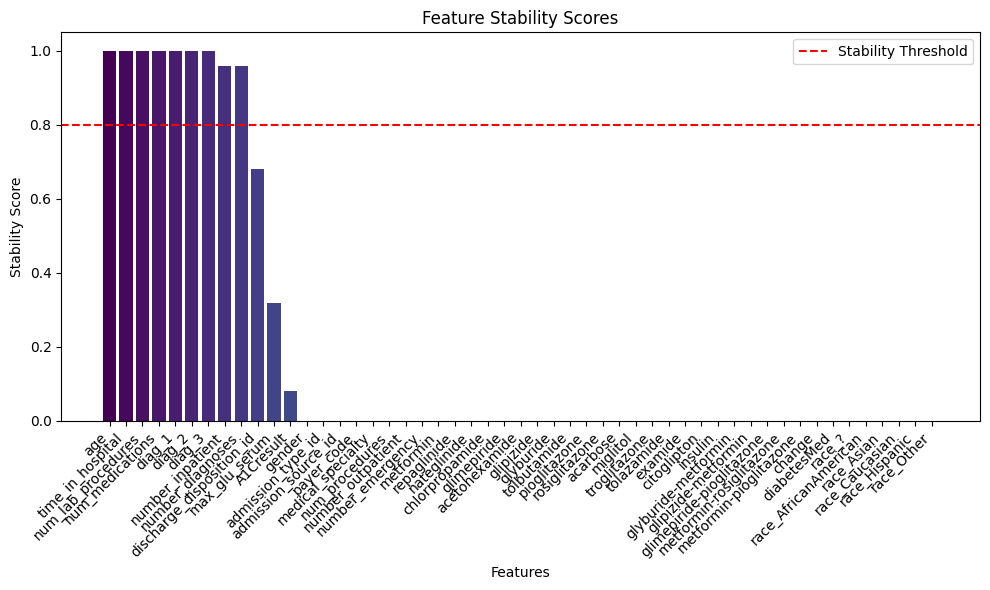

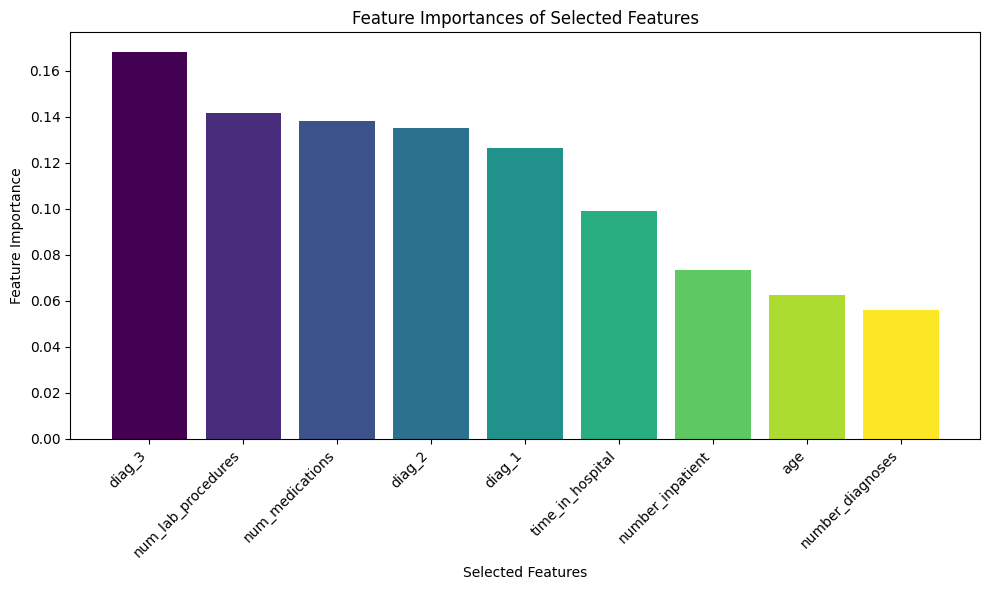

In [12]:
# Bar Plot for Stability Scores
plt.figure(figsize=(10, 6))
sorted_scores = sorted(stability_scores.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_scores)
colors = cm.viridis(np.linspace(0, 1, len(features)))
plt.bar(features, scores, color=colors)
plt.axhline(y=stability_threshold, color='r', linestyle='--', label='Stability Threshold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Stability Score')
plt.title('Feature Stability Scores')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
colors = cm.viridis(np.linspace(0, 1, len(selected_features)))
plt.bar(range(len(selected_features)), importances[sorted_indices], color=colors)
plt.xticks(range(len(selected_features)), [selected_features[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlabel('Selected Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances of Selected Features')
plt.tight_layout()
plt.show()

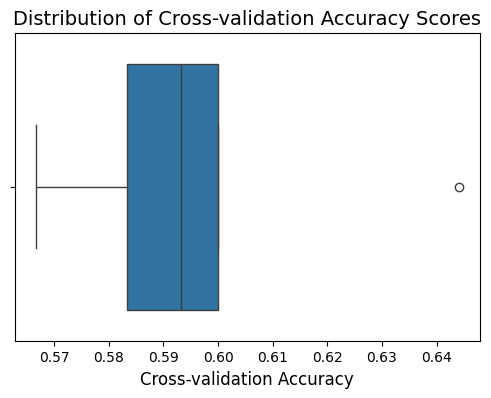

In [13]:
# Plot the cross-validation accuracy scores
plt.figure(figsize=(6, 4))
sns.boxplot(data=cv_scores, orient='h')
plt.xlabel('Cross-validation Accuracy', fontsize=12)
plt.title('Distribution of Cross-validation Accuracy Scores', fontsize=14)
plt.show()

# A. Traditional Model Selection

In [25]:
# Define the models to evaluate
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVM', SVC(probability=True))
]

# Define the hyperparameters to tune for each model
hyperparameters = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Evaluate each model using cross-validation and grid search
best_model = None
best_score = 0

# For plotting purposes
results = []

for name, model in models:
    print(f"Evaluating {name}...")
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(model, hyperparameters[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Evaluate the model on the testing set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])

    # Plot the evaluation metrics for the current model
    results.append([accuracy, precision, recall, f1, auc_roc])
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print()
    
    # Update the best model if the current model has a higher AUC-ROC score
    if auc_roc > best_score:
        best_model = grid_search.best_estimator_
        best_score = auc_roc

print(f"Best model: {best_model}")

Evaluating Logistic Regression...
Best parameters: {'C': 0.1}
Accuracy: 0.6333
Precision: 0.6522
Recall: 0.8333
F1-score: 0.7317
AUC-ROC: 0.7164

Evaluating Decision Tree...


/Users/tramngo/Desktop/JHU/PGM/Project/pgm-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tramngo/Desktop/JHU/PGM/Project/pgm-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Best parameters: {'max_depth': 3, 'min_samples_split': 10}
Accuracy: 0.5500
Precision: 0.6452
Recall: 0.5556
F1-score: 0.5970
AUC-ROC: 0.5822

Evaluating Random Forest...
Best parameters: {'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.6667
Precision: 0.6481
Recall: 0.9722
F1-score: 0.7778
AUC-ROC: 0.6968

Evaluating Gradient Boosting...
Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Accuracy: 0.6667
Precision: 0.6538
Recall: 0.9444
F1-score: 0.7727
AUC-ROC: 0.7384

Evaluating SVM...
Best parameters: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.6500
Precision: 0.6667
Recall: 0.8333
F1-score: 0.7407
AUC-ROC: 0.6701

Best model: GradientBoostingClassifier(learning_rate=0.01)


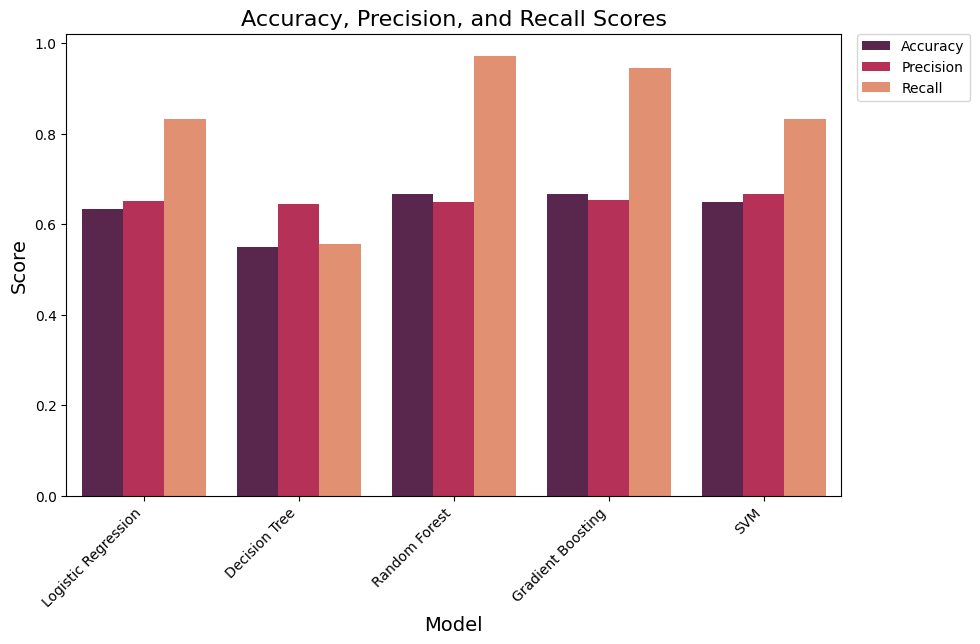

In [26]:
model_names = [name for name, _ in models]
accuracy_scores = [result[0] for result in results]
precision_scores = [result[1] for result in results]
recall_scores = [result[2] for result in results]

# Create a dataset for plotting
data = pd.DataFrame({
    'Model': model_names * 3,
    'Metric': ['Accuracy'] * len(model_names) + ['Precision'] * len(model_names) + ['Recall'] * len(model_names),
    'Score': accuracy_scores + precision_scores + recall_scores
})

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='rocket')

# Set the title and axis labels
plt.title('Accuracy, Precision, and Recall Scores', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Show the plot
plt.show()

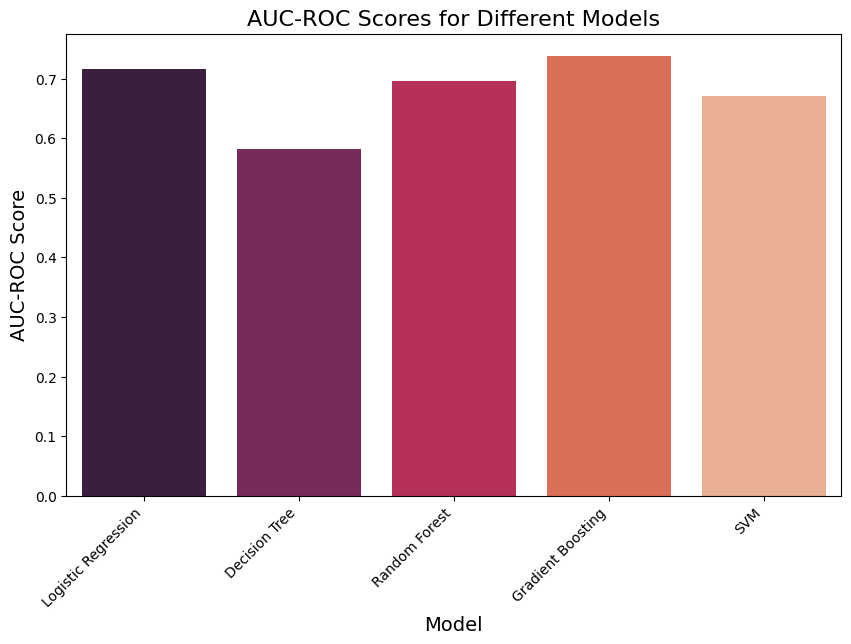

In [27]:
# Extract the AUC-ROC scores from the results
auc_roc_scores = [result[-1] for result in results]

# Create a dataset for plotting
data = pd.DataFrame({
    'Model': model_names,
    'AUC-ROC Score': auc_roc_scores
})

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(x='Model', y='AUC-ROC Score', data=data, palette='rocket')

# Set the title and axis labels
plt.title('AUC-ROC Scores for Different Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC-ROC Score', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [28]:
best_model, best_score

(GradientBoostingClassifier(learning_rate=0.01), 0.7384259259259259)

## B. Markov Model

### Calculate count & probability for each count => Define potential values for each variable's potential function

In [29]:
def calculate_variable_probabilities(variable):
    value_counts = variable.value_counts()
    total_count = variable.count()
    
    # Create a dictionary to store the count and probability of each unique value
    probabilities = {}
    
    # Iterate over each unique value and calculate its probability
    for value, count in value_counts.items():
        probability = count / total_count
        probabilities[value] = {'count': count, 'probability': probability}
    
    return probabilities

In [30]:
X_selected = X[selected_features]

In [31]:
for feature in selected_features:
    prob = calculate_variable_probabilities(X_selected[feature])
    print(f"{feature}:\n {prob}")

age:
 {55: {'count': 66, 'probability': 0.2214765100671141}, 65: {'count': 62, 'probability': 0.2080536912751678}, 75: {'count': 61, 'probability': 0.20469798657718122}, 85: {'count': 42, 'probability': 0.14093959731543623}, 45: {'count': 40, 'probability': 0.1342281879194631}, 35: {'count': 17, 'probability': 0.05704697986577181}, 25: {'count': 6, 'probability': 0.020134228187919462}, 15: {'count': 4, 'probability': 0.013422818791946308}}
time_in_hospital:
 {4: {'count': 51, 'probability': 0.17114093959731544}, 6: {'count': 37, 'probability': 0.12416107382550336}, 2: {'count': 36, 'probability': 0.12080536912751678}, 5: {'count': 34, 'probability': 0.11409395973154363}, 3: {'count': 34, 'probability': 0.11409395973154363}, 7: {'count': 23, 'probability': 0.07718120805369127}, 1: {'count': 17, 'probability': 0.05704697986577181}, 9: {'count': 15, 'probability': 0.050335570469798654}, 8: {'count': 15, 'probability': 0.050335570469798654}, 10: {'count': 14, 'probability': 0.0469798657718

### Construct Potential functions for each variable

In [32]:
from pgmpy.factors.discrete import DiscreteFactor

def construct_potential_functions(df, variables):
    potential_functions = {}
    
    for variable in variables:
        # Calculate probabilities for the variable
        probabilities = calculate_variable_probabilities(df[variable])
        
        # Extract the unique values and their corresponding probabilities
        values = list(probabilities.keys())
        probs = [probabilities[value]['probability'] for value in values]
        
        # Create a DiscreteFactor for the variable
        factor = DiscreteFactor([variable], [len(values)], probs)
        
        potential_functions[variable] = factor
    
    return potential_functions

In [34]:
# Construct the potential functions for each variable
potential_functions = construct_potential_functions(X_selected, selected_features)

# Print the potential functions
for variable, factor in potential_functions.items():
    print(f"Potential Function for {variable}:")
    print(factor)
    print()

Potential Function for age:
+--------+------------+
| age    |   phi(age) |
+========+============+
| age(0) |     0.2215 |
+--------+------------+
| age(1) |     0.2081 |
+--------+------------+
| age(2) |     0.2047 |
+--------+------------+
| age(3) |     0.1409 |
+--------+------------+
| age(4) |     0.1342 |
+--------+------------+
| age(5) |     0.0570 |
+--------+------------+
| age(6) |     0.0201 |
+--------+------------+
| age(7) |     0.0134 |
+--------+------------+

Potential Function for time_in_hospital:
+----------------------+-------------------------+
| time_in_hospital     |   phi(time_in_hospital) |
+======================+=========================+
| time_in_hospital(0)  |                  0.1711 |
+----------------------+-------------------------+
| time_in_hospital(1)  |                  0.1242 |
+----------------------+-------------------------+
| time_in_hospital(2)  |                  0.1208 |
+----------------------+-------------------------+
| time_in_hospi

### Study the pairwise relationship of each pair of variables => Needed for Pairwise Potential function

#### 1. Correlation Analysis

In [35]:
training_data = pd.concat([X_selected, y], axis=1)

correlation_matrix = training_data.corr(method="spearman")

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                         age  time_in_hospital  num_lab_procedures  \
age                 1.000000          0.154621           -0.072163   
time_in_hospital    0.154621          1.000000            0.282633   
num_lab_procedures -0.072163          0.282633            1.000000   
num_medications     0.058245          0.474992            0.327564   
number_inpatient    0.118071          0.134915           -0.043921   
diag_1             -0.006717         -0.002848           -0.107023   
diag_2              0.029984          0.054079            0.030975   
diag_3              0.028224          0.121292           -0.028415   
number_diagnoses    0.049904          0.214374            0.182942   
readmitted          0.075893          0.199749           -0.064353   

                    num_medications  number_inpatient    diag_1    diag_2  \
age                        0.058245          0.118071 -0.006717  0.029984   
time_in_hospital           0.474992          0.134915 -

From the correlation analysis (using both Peason and Spearman scores), if we use 0.3 as a threshold for medium to strong correlation, there are a few noticeable pairs: 

- `num_medications` and `number_diagnoses`
- `time_in_hospital` and `num_medications`
- `num_lab_procedures` and `num_medications`

### Implement the Markov model

In [36]:
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination

# Create an instance of the MarkovModel
model = MarkovNetwork()

# Add nodes (variables) to the model
variables = selected_features + ['readmitted']
model.add_nodes_from(variables)

# Add the potential functions (factors) to the model
for variable, factor in potential_functions.items():
    model.add_factors(factor)

# Add edges based on correlation analysis or domain knowledge
model.add_edge('number_inpatient', 'rebadmitted')
model.add_edge('num_medications', 'readmitted')
model.add_edge('time_in_hospital', 'readmitted')
model.add_edge('time_in_hospital', 'num_medications')
model.add_edge('num_lab_procedures', 'num_medications')
model.add_edge('num_medications', 'number_diagnoses')

# Create a factor for the target variable 'readmitted'
readmitted_factor = DiscreteFactor(['readmitted'], [2], [1 - y.mean(), y.mean()])
model.add_factors(readmitted_factor)

### Make inference with the model

In [48]:
# Create an instance of the VariableElimination class
inference = VariableElimination(model)

# Specify the query variable(s) and evidence (if any)
query_variables = ['readmitted']
evidence = {'num_medications': 5, 'time_in_hospital': 10}

# Perform inference
query_result = inference.query(query_variables, evidence)

# Print the inference results
print("Inference Results:")
print(query_result)

Inference Results:
+---------------+-------------------+
| readmitted    |   phi(readmitted) |
+===============+===================+
| readmitted(0) |            0.0006 |
+---------------+-------------------+
| readmitted(1) |            0.0008 |
+---------------+-------------------+


We can see that based on the provided evidence ({'num_medications': 5, 'time_in_hospital': 10}), the model suggests that the probability of readmission is slightly higher (0.08%) compared to non-readmission (0.06%).

However, the estimated probabilities are quite low (less than 1% for both cases). This could indicate that the model's predictive power is limited based on the given evidence and the current structure of the MRF model.

### Model refinement

In [ ]:
# # Create an instance of the MarkovModel
# model = MarkovNetwork()

# # Add nodes (variables) to the model
# variables = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications',
#              'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'readmitted']

# model.add_nodes_from(variables)

# # Add the potential functions (factors) to the model
# for variable, factor in potential_functions.items():
#     model.add_factors(factor)

# # Create a factor for the target variable 'readmitted'
# readmitted_factor = DiscreteFactor(['readmitted'], [2], [1 - y.mean(), y.mean()])
# model.add_factors(readmitted_factor)

# # Experiment with different model structures
# # Model 1: Add all edges
# model1 = model.copy()
# model1.add_edge('number_inpatient', 'readmitted')
# model1.add_edge('num_lab_procedures', 'readmitted')
# model1.add_edge('age', 'readmitted')
# model1.add_edge('num_medications', 'readmitted')
# model1.add_edge('diag_1', 'readmitted')
# model1.add_edge('diag_2', 'readmitted')
# model1.add_edge('diag_3', 'readmitted')
# model1.add_edge('time_in_hospital', 'readmitted')
# model1.add_edge('number_diagnoses', 'readmitted')
# model1.add_edge('time_in_hospital', 'num_medications')
# model1.add_edge('num_lab_procedures', 'num_medications')
# model1.add_edge('num_medications', 'number_diagnoses')

# # Model 2: Based on domain knowledge
# model2 = model.copy()
# model2.add_edge('age', 'readmitted')
# model2.add_edge('num_medications', 'readmitted')
# model2.add_edge('number_diagnoses', 'readmitted')

# # Model 3: Combining correlation analysis and domain knowledge
# model3 = model.copy()
# model3.add_edge('number_inpatient', 'readmitted')
# model3.add_edge('num_medications', 'readmitted')
# model3.add_edge('time_in_hospital', 'readmitted')
# model3.add_edge('age', 'readmitted')
# model3.add_edge('number_diagnoses', 'readmitted')

# # Perform inference and evaluate the models
# models = [model1, model2, model3]
# evidence = {'num_medications': 5, 'time_in_hospital': 10, "num_inpatient": 9}

# for i, model in enumerate(models, start=1):
#     print(f"Model {i}:")
#     inference = VariableElimination(model)
#     query_result = inference.query(['readmitted'], evidence)
#     print("Inference Results:")
#     print(query_result)
#     print()

## Model Evaluation

### Preprocess `X_test` to get it ready for evaluation 

In [38]:
def map_values_to_states(row, potential_functions):
    mapped_row = {}
    for variable, value in row.items():
        if variable in potential_functions:
            factor = potential_functions[variable]
            unique_values = factor.state_names[variable]
            if value in unique_values:
                mapped_value = unique_values.index(value)
                mapped_row[variable] = mapped_value
            else:
                # Handle unknown or unexpected values
                closest_value = min(unique_values, key=lambda x: abs(x - value) if isinstance(x, (int, float)) else float('inf'))
                mapped_value = unique_values.index(closest_value)
                mapped_row[variable] = mapped_value
        else:
            mapped_row[variable] = value
    return mapped_row

In [40]:
X_test_selected = X_test[selected_features]

In [41]:
for _, row in X_test_selected.iterrows():
    # Map the feature values to their corresponding state values
    mapped_row = map_values_to_states(row, potential_functions)

In [59]:
# Create an instance of the MarkovNetwork
model = MarkovNetwork()

# Add nodes (variables) to the model
variables = selected_features + ['readmitted']
model.add_nodes_from(variables)

# Add the potential functions (factors) to the model
for variable, factor in potential_functions.items():
    model.add_factors(factor)

# Add edges based on correlation analysis or domain knowledge
model.add_edge('number_inpatient', 'readmitted')
model.add_edge('num_medications', 'readmitted')
model.add_edge('time_in_hospital', 'readmitted')
model.add_edge('time_in_hospital', 'num_medications')
model.add_edge('num_lab_procedures', 'num_medications')
model.add_edge('num_medications', 'number_diagnoses')

# Create a factor for the target variable 'readmitted'
readmitted_factor = DiscreteFactor(['readmitted'], [2], [1 - y.mean(), y.mean()])
# readmitted_factor = DiscreteFactor(['readmitted'], [2], [0.5, 0.5])
model.add_factors(readmitted_factor)

# Create an instance of the VariableElimination class
inference = VariableElimination(model)

# Evaluate the Markov network model on the testing set
y_pred_markov = []
y_pred_proba_markov = []

for _, row in X_test_selected.iterrows():
    # Map the feature values to their corresponding state values
    mapped_row = map_values_to_states(row, potential_functions)
    evidence = mapped_row
    query_result = inference.query(['readmitted'], evidence)
    predicted_class = query_result.values.ravel().argmax()
    predicted_proba = query_result.values.ravel()
    y_pred_markov.append(predicted_class)
    y_pred_proba_markov.append(predicted_proba)

y_pred_proba_markov = np.array(y_pred_proba_markov)

# Calculate the evaluation metrics
accuracy_markov = accuracy_score(y_test, y_pred_markov)
precision_markov = precision_score(y_test, y_pred_markov)
recall_markov = recall_score(y_test, y_pred_markov)
f1_markov = f1_score(y_test, y_pred_markov)
auc_roc_markov = roc_auc_score(y_test, y_pred_proba_markov[:, 1])

print("Markov Network Model Evaluation:")
print(f"Accuracy: {accuracy_markov:.4f}")
print(f"Precision: {precision_markov:.4f}")
print(f"Recall: {recall_markov:.4f}")
print(f"F1-score: {f1_markov:.4f}")
print(f"AUC-ROC: {auc_roc_markov:.4f}")
print()

Markov Network Model Evaluation:
Accuracy: 0.6000
Precision: 0.6000
Recall: 1.0000
F1-score: 0.7500
AUC-ROC: 0.2928



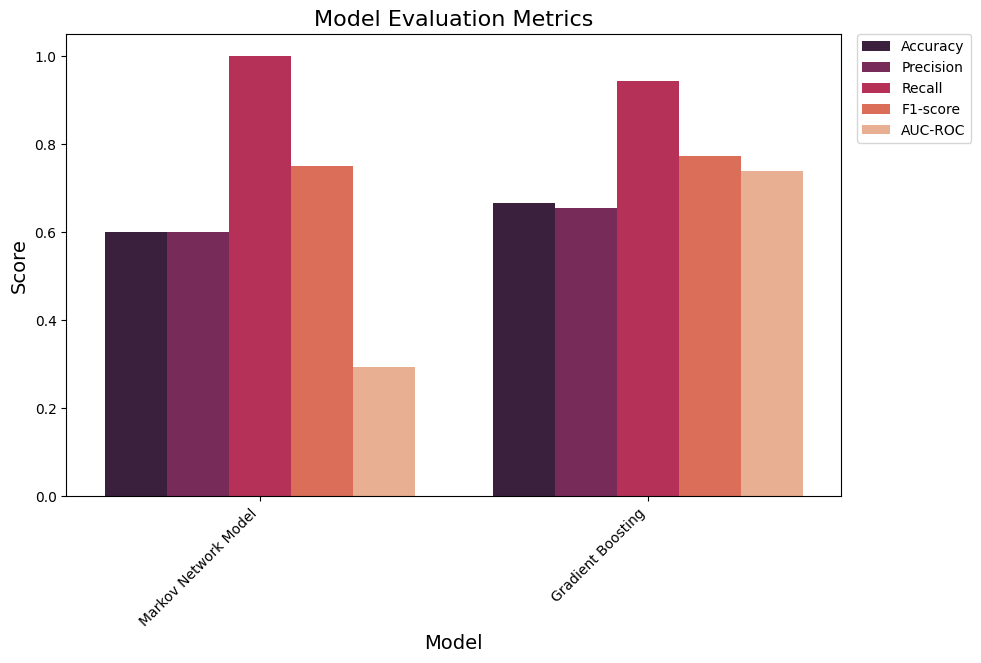

In [43]:
# Define the model names and their respective scores
model_names = ['Markov Network Model', 'Gradient Boosting']
accuracy_scores = [0.6000, 0.6667]
precision_scores = [0.6000, 0.6538]
recall_scores = [1.0000, 0.9444]
f1_scores = [0.7500, 0.7727]
auc_roc_scores = [0.2928, 0.7384]

# Create a dataset for plotting
data = {
    'Model': model_names * 5,
    'Metric': ['Accuracy'] * 2 + ['Precision'] * 2 + ['Recall'] * 2 + ['F1-score'] * 2 + ['AUC-ROC'] * 2,
    'Score': accuracy_scores + precision_scores + recall_scores + f1_scores + auc_roc_scores
}

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='rocket')

# Set the title and axis labels
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Show the plot
plt.show()

## Model Comparision

#### 1. Accuracy:

Gradient Boosting Classifier: 0.6667 (66.67%)

Markov Network Model: 0.6 (60%) 

The Gradient Boosting Classifier has a higher accuracy, correctly predicting the target variable for a larger proportion of instances compared to the Markov Network Model.

#### 2. Precision:
   
Gradient Boosting Classifier: 0.6538 (65.38%)

Markov Network Model: 0.6 (60%) 

The Gradient Boosting Classifier has a higher precision, indicating that among the instances it predicted as positive (readmitted), a larger proportion of them are actually positive compared to the Markov Network Model.

#### 3. Recall:

Gradient Boosting Classifier: 0.9444 (94.44%)

Markov Network Model: 1.0000 (100.00%) 

The Markov Network Model has a perfect recall of 1.0000, meaning it correctly identifies all the actual positive instances. In contrast, the Gradient Boosting Classifier has a recall of 0.7429, indicating that it misses some positive instances.

#### 4. F1-score:

Gradient Boosting Classifier: 0.7727 (77.27%)

Markov Network Model: 0.75 (75%) 

The Markov Network Model has a slightly higher F1-score, which is the harmonic mean of precision and recall. This suggests that the Markov Network Model has a better balance between precision and recall compared to the Gradient Boosting Classifier.

#### 5. AUC-ROC:

Gradient Boosting Classifier: 0.7384 (73.84%)

Markov Network Model: 0.2928 (29.28%) 

The Gradient Boosting Classifier has a significantly higher AUC-ROC score, indicating that it has a better ability to distinguish between positive and negative instances across different probability thresholds. The Markov Network Model's AUC-ROC score of 0.2928 suggests that it performs worse than random guessing (AUC-ROC of 0.5). The Markov Model is likely predicting a high number of false positives. In other words, while the model correctly identifies all the actual positive instances (perfect recall), it also incorrectly classifies many negative instances as positive, resulting in a high false positive rate.

Overall, the Gradient Boosting Classifier outperforms the Markov Network Model in terms of accuracy, precision, and AUC-ROC. It has a better overall predictive performance and a stronger ability to discriminate between positive and negative instances.

However, the Markov Network Model has a perfect recall, meaning it captures all the positive instances, but at the cost of lower precision. The Markov Network Model has an F1 score of 0.7500, indicating a relatively good balance between precision and recall.